***OBJECTIVES 1***

- using training set, calculate recovery for (rougher.output.recovery), find MAE between calculations and actuals
- which features are not available in the test set? what are they? their type?
- perfrom preprocessing, duplicates? missing?, feature scaling

***NOTES***

1. recovery(ROUGHER.output.recovery) = ((rougher.output.concentrate_au * (rougher.input.feed_au - rougher.output.tail_au)) / (rougher.input.feed_au * (rougher.output.concentrate_au - rougher.output.tail_au))) * 100%

2. recovery(FINAL.output.recovery) = ((final.output.concentrate_au * (rougher.output.concentrate_au - final.output.tail_au)) / (rougher.output.concentrate_au * (final.output.concentrate_au - final.output.tail_au))) * 100%

In [1]:
import pandas as pd
import numpy as np

data_full = pd.read_csv('gold_recovery_full.csv')
data_train = pd.read_csv('gold_recovery_train.csv')
data_test = pd.read_csv('gold_recovery_test.csv')

# setting 'date' column to be our new index
data_full = data_full.set_index('date')
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')

# lists of variables used for recovery calculations
rougher_recovery_features = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']
final_recovery_features = ['final.output.concentrate_au', 'rougher.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']

# displaying non-missing/missing values and their combinations, including percentage as decimal
print(data_train[rougher_recovery_features].isna().value_counts())
print(data_train[rougher_recovery_features].isna().sum())
print(data_train[rougher_recovery_features].isna().sum() / len(data_train))
print()
print(data_train[final_recovery_features].isna().value_counts())
print(data_train[final_recovery_features].isna().sum())
print(data_train[final_recovery_features].isna().sum() / len(data_train))

#print(data_full.info())
#print(data_train.info())
#print(data_test.info())
#print(data_full.isna().sum())
#print(data_train.isna().sum())
#print(data_test.isna().sum())
#print(data_full.sample(20, random_state=777))

rougher.output.concentrate_au  rougher.input.feed_au  rougher.output.tail_au  rougher.output.recovery
False                          False                  False                   False                      14287
                                                      True                    True                        2167
                                                      False                   True                         323
True                           True                   True                    True                          82
False                          True                   False                   True                           1
Name: count, dtype: int64
rougher.output.concentrate_au      82
rougher.input.feed_au              83
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64
rougher.output.concentrate_au    0.004864
rougher.input.feed_au            0.004923
rougher.output.tail_au           0.133393
rougher.output.recovery   

**- All 3 data sets are missing values "randomly" in almost every column, with ['date'] being the functional index seeing as though none of the datetime columns are missing any values in any of the data sets**

**- Only 2 dtypes across all 3 data sets (object, float64), ['date'] (the only object) will be our index, so there is no need to convert dtypes**

**- There are 2,573 rows we cannot use to validate rougher.output.recovery due to at least one parameter missing, I will be creating a separate df containing only non-missing recovery parameters**

**- There are 1,521 rows that cannot be used to validate final.output.recovery for the same reason as above**

In [48]:
# df containing non-null parameters and output recovery for both rougher and final
calculation_features = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au',
                        'rougher.output.recovery', 'final.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']
calculation_features_df = data_train[calculation_features].dropna()

# function: rougher output recovery
def rougher_recovery(df):
    C = df['rougher.output.concentrate_au'] # concentrate after flotation
    F = df['rougher.input.feed_au'] # feed before flotation
    T = df['rougher.output.tail_au'] # tail after flotation
    recovery = np.where(F * (C - T) != 0, (C * (F - T)) / (F * (C - T)) * 100, 0)
    return pd.Series(recovery)

# function: final output recovery
def final_recovery(df):
    C = df['final.output.concentrate_au'] # concentrate after purification
    F = df['rougher.output.concentrate_au'] # concentrate after flotation
    T = df['final.output.tail_au'] # tails after purification
    recovery = np.where(F * (C - T) != 0, (C * (F - T)) / (F * (C - T)) * 100, 0)
    return pd.Series(recovery)

# import MAE and verify accuracy of data
from sklearn.metrics import mean_absolute_error as mae

rougher_actual = calculation_features_df['rougher.output.recovery']
rougher_calculated = rougher_recovery(calculation_features_df)

final_actual = calculation_features_df['final.output.recovery']
final_calculated = final_recovery(calculation_features_df)

print('Mean Absolute Error (rougher.output.recovery): ', mae(rougher_actual, rougher_calculated), end=' %\n')
print('Mean Absolute Error (final.output.recovery): ', mae(final_actual, final_calculated), end=' %')

Mean Absolute Error (rougher.output.recovery):  9.317053768151204e-15 %
Mean Absolute Error (final.output.recovery):  25.37306375918405 %

**- With an MAE so close to zero (0.000000000000009317), we can see that the existing data from the warehouse correctly implemented the recovery equation to find output values for rougher.output.recovery**

**- Since I had the framework for validating recovery against rougher.output, I decided to also check the accuracy of final.output.recovery using the equation, and our calculated values are off by an average of 25.4% for all observations. The chosen parameters have yielded the lowest final.recovery MAE for a few combinations, and I believe we should continue with the assumption that the final.output.recovery column in the original data is incorrect. We will be using calculated values instead of the origninal for our target when training to predict final recovery**

In [ ]:
# creating sets of column names, subtraction gives us columns not present within the test set
cols_train = set(data_train.columns)
cols_test = set(data_test.columns)
train_unique = cols_train - cols_test

print(train_unique)
print(len(train_unique))

{'final.output.tail_sol', 'rougher.output.tail_pb', 'final.output.recovery', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_au', 'rougher.output.tail_sol', 'final.output.concentrate_ag', 'rougher.calculation.au_pb_ratio', 'secondary_cleaner.output.tail_pb', 'final.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concentrate_pb', 'rougher.output.recovery', 'rougher.output.concentrate_sol', 'rougher.output.tail_ag', 'final.output.tail_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate_ag', 'final.output.tail_pb', 'primary_cleaner.output.tail_au', 'final.output.concentrate_sol', '

**- The test set is missing 34 features compared to the training and full sets. 30 of them are of the 'output' parameter type, 4 of them are 'calculation'**

**- Next steps:**

**- Merge missing features from data_full back into data_test, matched by index, for future model analysis**

**- Keep rougher.output.recovery target, change final.output.recovery to calculated values for accuracy**

**- Handle missing values accordingly**

Percentage of rows with missing entries: 13.30% test set
Percentage of rows with missing entries: 34.66% train set
Percentage of rows with missing entries: 29.15% full set


<Figure size 640x480 with 0 Axes>

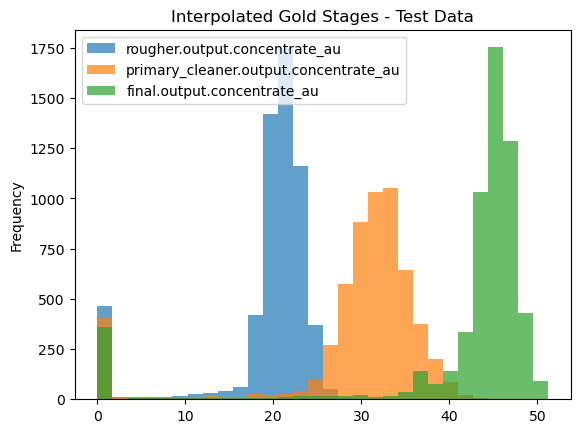

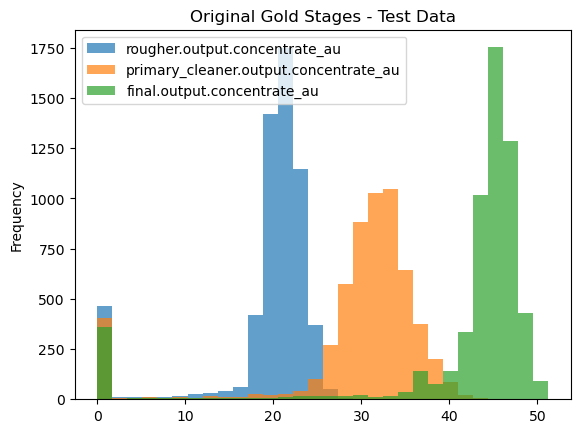

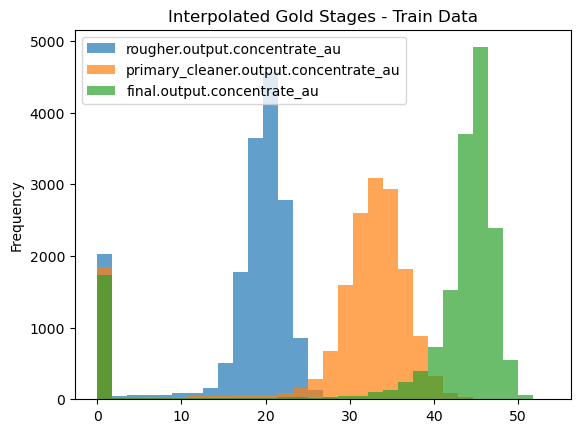

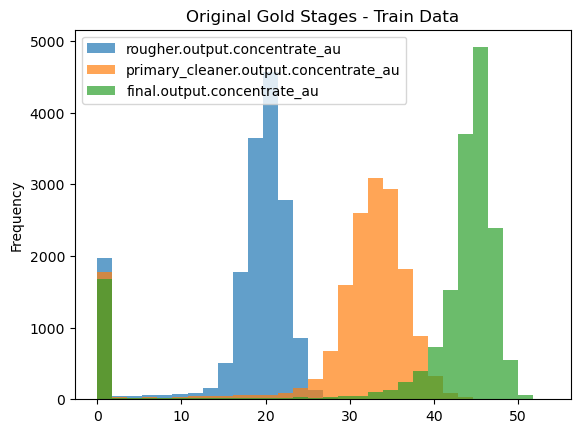

Percentage of rows with missing entries: 0.00% test set
Percentage of rows with missing entries: 0.00% train set


In [65]:
data_test_refill = data_full.loc[data_test.index]

#print(data_test_clean['secondary_cleaner.state.floatbank4_a_level'].sample(10, random_state=12345))
#print(data_test['secondary_cleaner.state.floatbank4_a_level'].sample(10, random_state=12345))

# function: extract percentage of rows with missing values
def percentage_missing(df):
    rows_nan = df.isnull().any(axis=1).sum()
    total_rows = len(df)
    percentage = (rows_nan / total_rows) * 100
    return f'Percentage of rows with missing entries: {percentage:.2f}%'

print(percentage_missing(data_test_refill), 'test set')
print(percentage_missing(data_train), 'train set')
print(percentage_missing(data_full), 'full set')

# function: handle missing values with interpolation, time based observations, continuous numerical data
def handle_nan(df):
    df_cleaned = df.copy()
    for column in df_cleaned.columns:
        df_cleaned[column] = df_cleaned[column].interpolate(method='linear')
    return df_cleaned

# applying interpolation to both the training and test sets
data_test_cleaned = handle_nan(data_test_refill)
data_train_cleaned = handle_nan(data_train)

# analyzing integrity of data after being filled
from matplotlib import pyplot as plt

gold_concentrate_stages = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
silver_concentrate_stages = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
lead_concentrate_stages = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

plt.figure()

data_test_cleaned[gold_concentrate_stages].plot(kind='hist', bins=30, alpha=.7, title='Interpolated Gold Stages - Test Data')
data_test_refill[gold_concentrate_stages].plot(kind='hist', bins=30, alpha=.7, title='Original Gold Stages - Test Data')

data_train_cleaned[gold_concentrate_stages].plot(kind='hist', bins=30, alpha=.7, title='Interpolated Gold Stages - Train Data')
data_train[gold_concentrate_stages].plot(kind='hist', bins=30, alpha=.7, title='Original Gold Stages - Train Data')


plt.show()

print(percentage_missing(data_test_cleaned), 'test set')
print(percentage_missing(data_train_cleaned), 'train set')